# How much data is enough?

Here we want to investigate the scaling behaviour of the model performance as more training data are available (by simulation, of course).

In [1]:
from bioLearningPractical.generateTSDataSet import *
from bioLearningPractical.plot import *
from scipy.integrate import quad

We have generated 10,000 sets of time-series data with different protein profiles but share the same kinetic constants. Here we create 4 groups of time series randomly sampled from this pool of 10,000. Since we need to repeat the predictions multiple times, we have to actually create sufficient training strains for this purpose.

In [2]:
## EDIT THIS TO CHANGE NUMBER OF TRAINING/TEST STRAINS

simulated_data_file_path = 'data/limonene_simulated_n10000.csv'
machine_learning_model = 'RF'
data_type = 'simulated'

strain_numbers = [2, 4, 16, 256] # number of strains to generate
training_sets = 10 # number of times the prediction should be repeated for each strain number

# also specify how many test strains to generate
test_strains = 1200

Need to calculate how many strains to sample, since we want 10 unique training sets for each group.

In [3]:
# Generate time-series data (strains) to sample from
strains_needed = (max(strain_numbers) + 1)*training_sets + 1 + 2000
print("Training strains needed: ", strains_needed)

# how many training sets
# ref https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
train_sizes = []
for strain_number in strain_numbers:
    train_size = (strain_number + 1) * training_sets / (strains_needed - 1)
    train_sizes.append(train_size)
print("Fraction of time-series sampled: ", train_sizes)

# sanity check: strain group
print("N strains (training): ", [int((strains_needed-1)*size/training_sets)-1 for size in train_sizes])
training_strains = strains_needed

Training strains needed:  4571
Fraction of time-series sampled:  [0.006564551422319475, 0.010940919037199124, 0.037199124726477024, 0.562363238512035]
N strains (training):  [2, 4, 16, 255]


In [4]:
file_name = simulated_data_file_path
y0 = [1e-5]*10
timeKey = 'Time'
df = pd.read_csv(file_name)
df = df.pivot_table(df,index=['Strain','Time'],aggfunc=np.sum)

strains = df.index.get_level_values(0).unique()
sample = random.sample(list(strains),training_strains+test_strains)

#create test df
test_df = df.loc[(sample[0:test_strains],slice(None))]

#create the training df
df = df.loc[(sample[test_strains:],slice(None))]

features = ['AtoB','HMGR','HMGS','MK','PMK','PMD','Idi','GPPS','LS']
targets=['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']
specific_features = {'Acetyl-CoA':      ['AtoB','Acetyl-CoA','Acetoacetyl-CoA','HMGR'],
                     'Acetoacetyl-CoA': ['AtoB','Acetyl-CoA','Acetoacetyl-CoA','HMGR','HMG-CoA'],
                     'HMG-CoA':         ['Acetyl-CoA','Acetoacetyl-CoA','HMGR','HMGS','HMG-CoA'],
                     'Mev':             ['Acetyl-CoA','Acetoacetyl-CoA','HMGS','HMG-CoA','MK','Mev','GPP','MevP'],
                     'MevP':            ['MK','Mev','GPP','MevP','PMK'],
                     'MevPP':           ['PMK','MevP','PMD','MevPP','Mev'],
                     'IPP':             ['PMD','MevPP','MevP','Mev','Idi','IPP','GPPS','DMAPP'],
                     'DMAPP':           ['Idi','IPP','GPPS','DMAPP'],
                     'GPP':             ['GPPS','IPP','DMAPP','GPP','LS'],
                     'Limonene':        ['LS','GPP']}

#Create TSDF for training strains
tsdf = generateTSDataSet(df, features, targets)

#Create Validation TSDF to test the models predictive power
test_tsdf = generateTSDataSet(test_df, features, targets)
display(test_tsdf)

Total Time Series in Data Set:  4571
Total Time Series in Data Set:  1200


feature                                            \
                          AtoB          HMGR          HMGS            MK   
Strain Time (h)                                                            
6      0.000000   5.253105e+05  3.792650e+05  2.356569e+05  3.114812e+05   
       0.717172   3.250018e+06  2.994172e+06  1.602476e+06  2.127087e+06   
       1.434343   5.306515e+06  5.013094e+06  2.649241e+06  3.514808e+06   
       2.151515   6.694802e+06  6.436033e+06  3.375950e+06  4.474645e+06   
       2.868687   7.022815e+06  6.959339e+06  3.602473e+06  4.764656e+06   
...                        ...           ...           ...           ...   
9995   68.131313  9.418575e+06  4.678215e+06  9.430997e+06  4.740651e+06   
       68.848485  9.421636e+06  4.687936e+06  9.433427e+06  4.750383e+06   
       69.565657  9.397515e+06  4.679285e+06  9.414071e+06  4.756647e+06   
       70.282828  9.350689e+06  4.660682e+06  9.385353e+06  4.764393e+06   
       71.000000  9.281158e+06  4.632127e+06  9.347272e+06  4.773622e+06   

                                                                          \
                           PMK           PMD           Idi          GPPS   
Strain Time (h)                                                            
6      0.000000   2.941712e+05  1.517984e+05  3.362391e+05  6.919974e+05   
       0.717172   2.315654e+06  1.197599e+06  2.758692e+06  4.009651e+06   
       1.434343   3.883444e+06  2.006922e+06  4.641976e+06  6.501252e+06   
       2.151515   4.997541e+06  2.579766e+06  5.986091e+06  8.166799e+06   
       2.868687   5.423800e+06  2.798526e+06  6.516079e+06  8.485904e+06   
...                        ...           ...           ...           ...   
9995   68.131313  8.293047e+06  3.788005e+06  7.059552e+06  6.406442e+06   
       68.848485  8.290461e+06  3.789698e+06  7.045419e+06  6.403953e+06   
       69.565657  8.313624e+06  3.783641e+06  7.048197e+06  6.422566e+06   
       70.282828  8.355043e+06  3.774295e+06  7.057141e+06  6.453132e+06   
       71.000000  8.414718e+06  3.761660e+06  7.072252e+06  6.495650e+06   

                                           ...              target   feature  \
                            LS Acetyl-CoA  ...     MevPP     MevPP       IPP   
Strain Time (h)                            ...                                 
6      0.000000   3.921081e+05   0.198179  ...  0.201783 -0.004904  0.198848   
       0.717172   2.969688e+06   0.200352  ...  0.198301 -0.004958  0.203640   
       1.434343   4.950979e+06   0.202435  ...  0.194743 -0.005066  0.208375   
       2.151515   6.335981e+06   0.204427  ...  0.191108 -0.005058  0.213055   
       2.868687   6.809923e+06   0.206483  ...  0.187560 -0.004951  0.217877   
...                        ...        ...  ...       ...       ...       ...   
9995   68.131313  1.377066e+06   0.323962  ...  0.020404 -0.000475  0.503012   
       68.848485  1.375540e+06   0.325837  ...  0.020069 -0.000389  0.506569   
       69.565657  1.376834e+06   0.326988  ...  0.019851 -0.000253  0.506873   
       70.282828  1.380721e+06   0.327901  ...  0.019709 -0.000146  0.505635   
       71.000000  1.387201e+06   0.328576  ...  0.019643 -0.000093  0.502856   

                    target   feature    target   feature    target  \
                       IPP     DMAPP     DMAPP       GPP       GPP   
Strain Time (h)                                                      
6      0.000000   0.006749  0.199194  0.000401  0.201005 -0.000413   
       0.717172   0.006709  0.199478  0.000334  0.200712 -0.000558   
       1.434343   0.006630  0.199667  0.000199  0.200213 -0.000848   
       2.151515   0.006692  0.199761  0.000353  0.199508 -0.001280   
       2.868687   0.006380  0.200169 -0.000020  0.198395 -0.001380   
...                    ...       ...       ...       ...       ...   
9995   68.131313  0.004440  0.201552 -0.000166  0.190124 -0.000544   
       68.848485  0.002719  0.201150 -0.000765  0.189856 -0.000709   
  

In [5]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
model_str = machine_learning_model
if model_str == 'RF':
    mlmodel = RandomForestRegressor(n_estimators=20)

In [6]:
# now subset the data frame to have the required number of strains
if data_type == 'simulated':
    strains = tsdf.index.get_level_values(0).unique()
    tsdf_max_strains = tsdf.loc[slice(strains[0],strains[max(strain_numbers)]),slice(None)]
else:
    tsdf_max_strains = tsdf
    
tsdf_max_strains.index.get_level_values(0).unique()

Int64Index([  1,   7,   8,  12,  18,  23,  27,  28,  29,  31,
            ...
            549, 550, 551, 552, 559, 562, 564, 565, 566, 568],
           dtype='int64', name='Strain', length=257)

Legacy codes: the cell below trains a model using the entire training data. But this is not necessary for our purpose here.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Acetyl-CoA


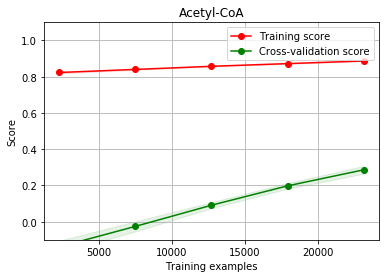

Cross Validated Pearson R: 0.892872


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Acetoacetyl-CoA


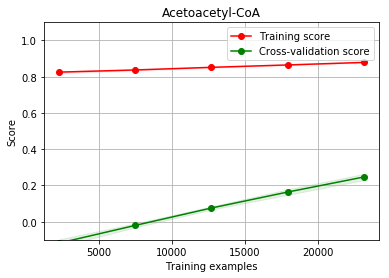

Cross Validated Pearson R: 0.884100


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


HMG-CoA


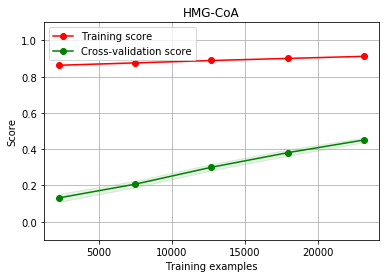

Cross Validated Pearson R: 0.917900


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Mev


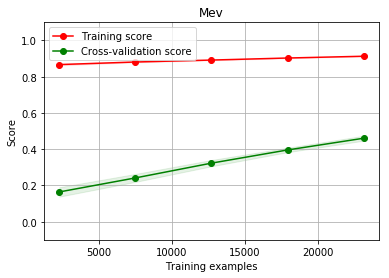

Cross Validated Pearson R: 0.918606


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


MevP


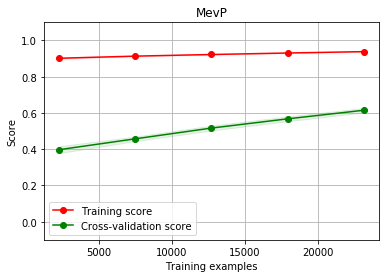

Cross Validated Pearson R: 0.942658


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


MevPP


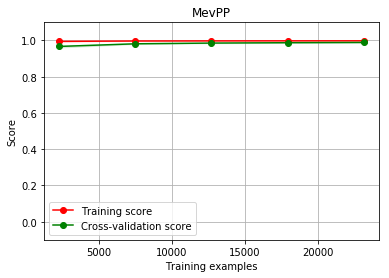

Cross Validated Pearson R: 0.998237


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


IPP


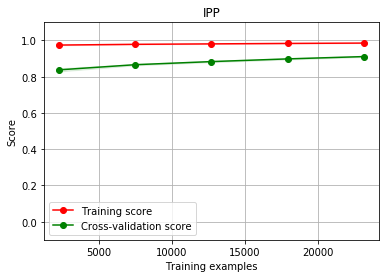

Cross Validated Pearson R: 0.986547


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


DMAPP


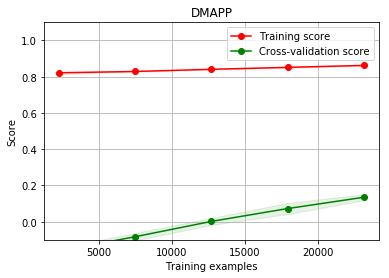

Cross Validated Pearson R: 0.868092


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


GPP


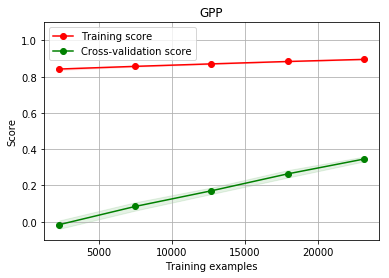

Cross Validated Pearson R: 0.900587


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Limonene


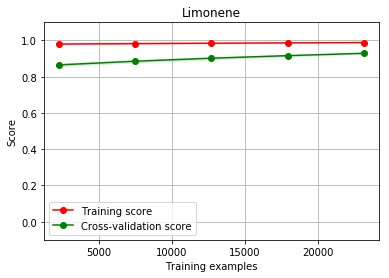

Cross Validated Pearson R: 0.989265
Average Training Score: 0.9298861944512515 n: 10


In [7]:
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.base import clone

modelDict = {}
average_training_score = 0
n = 0
for target_index in tsdf_max_strains.columns:
    if target_index[0] == 'feature':
        continue
    n += 1
    target = target_index[1]

    # TODO: should not convert to list, otherwise it produces cryptic error messages about numerical issues
    val_X = tsdf_max_strains['feature'].values.tolist()
    val_y = tsdf_max_strains[target_index].values.tolist()
    
    #rescaling is actually needed only for Limonene, see notebook 5
    X = preprocessing.scale(val_X)
    y = preprocessing.scale(val_y)

    if model_str == 'tpot':
        modelDict[target] = clone(mlmodel).fit(np.array(X),np.array(y)).fitted_pipeline_
        try:
            crossValPlot = plot_learning_curve(modelDict[target],target,X,y,cv=ShuffleSplit())
        except:
            pass
    else:
        modelDict[target] = clone(mlmodel)
        crossValPlot = plot_learning_curve(modelDict[target], target, X, y, cv=ShuffleSplit())
    
    ax = plt.gca()
    ax.set_ylim([-0.1, 1.1])
    strip_target = ''.join([char for char in target if char != '/'])
    print(strip_target)
    crossValPlot.savefig('figures/' + strip_target + 'CrossValPlot.pdf',transparent=False)
    plt.show()
    
    #Save out Cross Validation Plot
    
    modelDict[target] = modelDict[target].fit(X,y)
    
    score = modelDict[target].score(X,y)
    print('Cross Validated Pearson R: {:f}'.format(score))
    average_training_score +=  score
    #print(modelDict[target_name].predict([reduced_features[2]]))
    
average_training_score /= n
print('Average Training Score:',average_training_score,'n:',n)

In [10]:
# check if any values are below/above machine precision

tsdf_max_strains['feature'].describe()

,AtoB,HMGR,HMGS,MK,PMK,PMD,Idi,GPPS,LS,Acetyl-CoA,Acetoacetyl-CoA,HMG-CoA,Mev,MevP,MevPP,IPP,DMAPP,GPP,Limonene
count,2.570000e+04,2.570000e+04,2.570000e+04,2.570000e+04,2.570000e+04,2.570000e+04,2.570000e+04,2.570000e+04,2.570000e+04,25700.000000,25700.000000,25700.000000,25700.000000,25700.000000,25700.000000,25700.000000,25700.000000,25700.000000,2.570000e+04
mean,5.406828e+06,5.616098e+06,5.147341e+06,5.100149e+06,5.256497e+06,5.332590e+06,5.253655e+06,5.385810e+06,5.275167e+06,0.268817,0.206008,0.170423,0.204596,0.178641,0.058084,0.388254,0.199991,0.182135,1.786872e-02
std,2.566324e+06,2.504709e+06,2.478098e+06,2.524465e+06,2.586660e+06,2.571303e+06,2.618519e+06,2.511732e+06,2.643725e+06,0.039885,0.005141,0.021406,0.017661,0.027459,0.058452,0.080560,0.000892,0.014067,1.405477e-02
min,5.299851e+04,5.025192e+04,4.289145e+04,5.273198e+04,5.707292e+04,4.435847e+04,4.692202e+04,4.953326e+04,4.431970e+04,0.196946,0.196110,0.109285,0.138156,0.089440,0.002175,0.196330,0.196326,0.139547,1.000000e-09
25%,3.210239e+06,3.457501e+06,3.185321e+06,3.047036e+06,2.948349e+06,3.367187e+06,2.866540e+06,3.211122e+06,3.073782e+06,0.234509,0.201938,0.155196,0.196234,0.159576,0.011074,0.337069,0.199398,0.173152,6.323659e-03
50%,5.588728e+06,5.910962e+06,5.194956e+06,4.981656e+06,5.421109e+06,5.249094e+06,5.200254e+06,5.551913e+06,5.337181e+06,0.269120,0.204668,0.174247,0.202492,0.183446,0.030336,0.410125,0.199996,0.185575,1.445639e-02
75%,7.403965e+06,7.767338e+06,6.990899e+06,7.012116e+06,7.425994e+06,7.643252e+06,7.648491e+06,7.476203e+06,7.799685e+06,0.303094,0.209159,0.188358,0.212447,0.198753,0.096075,0.446919,0.200590,0.193610,2.691899e-02
max,9.995453e+06,1.004513e+07,9.863600e+06,9.994250e+06,9.974491e+06,9.984285e+06,9.988434e+06,1.000931e+07,1.002442e+07,0.350210,0.225386,0.203333,0.272981,0.254080,0.204586,0.545427,0.205013,0.203797,6.141467e-02


In [11]:
tsdf_max_strains['target'].describe()

,Acetyl-CoA,Acetoacetyl-CoA,HMG-CoA,Mev,MevP,MevPP,IPP,DMAPP,GPP,Limonene
count,25700.000000,25700.000000,25700.000000,25700.000000,25700.000000,25700.000000,25700.000000,2.570000e+04,25700.000000,25700.000000
mean,0.001941,0.000188,-0.000803,0.000072,-0.000551,-0.002581,0.003862,2.919713e-07,-0.000497,0.000499
std,0.000918,0.000692,0.000665,0.000809,0.000846,0.003525,0.003806,6.640902e-04,0.000655,0.000241
min,-0.003043,-0.003232,-0.003804,-0.003722,-0.003906,-0.022602,-0.006940,-3.250542e-03,-0.003575,-0.000093
25%,0.001351,-0.000272,-0.001240,-0.000488,-0.001124,-0.003342,0.001420,-4.421317e-04,-0.000929,0.000301
50%,0.001943,0.000189,-0.000810,0.000040,-0.000609,-0.001152,0.002956,-6.613609e-07,-0.000512,0.000491
75%,0.002535,0.000642,-0.000376,0.000602,-0.000015,-0.000214,0.005166,4.335258e-04,-0.000077,0.000689
max,0.007092,0.003525,0.002485,0.004091,0.003541,0.001476,0.022081,3.475207e-03,0.003076,0.001486


Here the function `plot_actual_predicted` from `bioLearningPractical` trains various models on 4 groups of time series data, each with different sizes.
- the training and prediction (on a test strain) is repeated 10 times for each group
- plot predictions for different training set size and plot also the confidence interval (standard deviation)

The standard deviation is an indication of the variability of pathway dynamics predictions due to stochastic effects of the optimization algorithms (e.g., different seeds) and lack of extrapolability from a reduced set of initial protein concentrations.

In [8]:
help(plot_actual_predicted)

Help on function plot_actual_predicted in module bioLearningPractical.plot:

plot_actual_predicted(modelDict, title, df, targets, specific_features, ylim=None, cv=None, n_jobs=1, train_sizes=array([0.1 , 0.55, 1.  ]), training_sets=5)
    Modified by Kevin S. for bioLearningPractical
    Adapted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    
    Generate a simple plot of actual vs predicted results. Returns Metrics for each predicted curve.
    Parameters
    ----------
    title : string
        Title for the chart.
    df: data frame to pass in (can be a multi-index dataframe from generateTSData).
    targets : array-like, shape (n_samples) or (n_samples, n_features)
        List of target names corresponding to df.
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strat

Training Models for Training Set 0 In Sample set 0
Training Models for Training Set 0 In Sample set 1
Training Models for Training Set 0 In Sample set 2
Training Models for Training Set 0 In Sample set 3
Training Models for Training Set 1 In Sample set 0
Training Models for Training Set 1 In Sample set 1
Training Models for Training Set 1 In Sample set 274747475
Training Models for Training Set 1 In Sample set 3
Training Models for Training Set 2 In Sample set 0
Training Models for Training Set 2 In Sample set 1
Training Models for Training Set 2 In Sample set 291919192 69.56565656565657
Training Models for Training Set 2 In Sample set 3
Training Models for Training Set 3 In Sample set 0
Training Models for Training Set 3 In Sample set 1
Training Models for Training Set 3 In Sample set 2757575758
Training Models for Training Set 3 In Sample set 3
Training Models for Training Set 4 In Sample set 0
Training Models for Training Set 4 In Sample set 103030303 51.63636363636363 63.8282828282

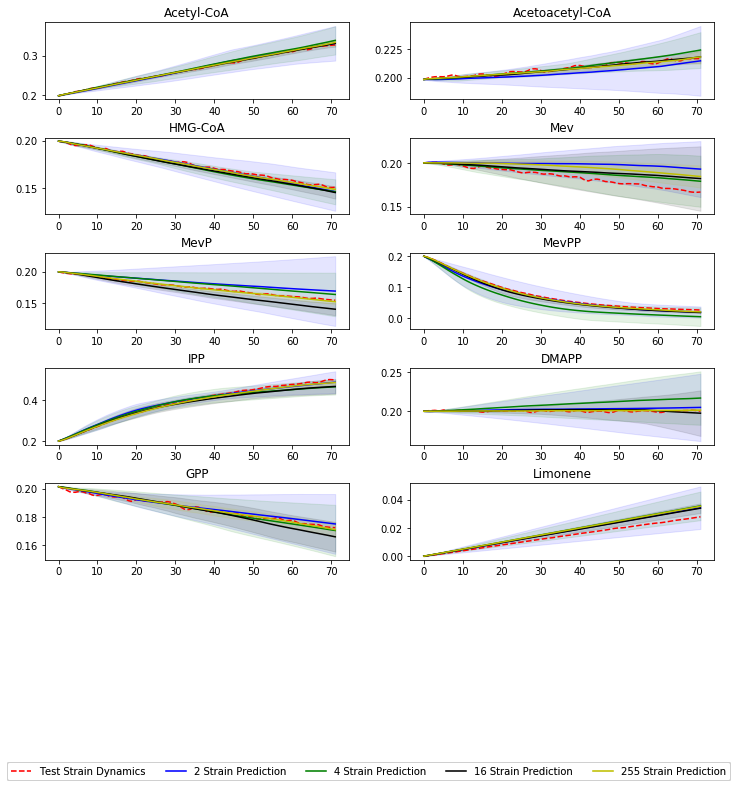

In [15]:
modelDict = {target: clone(mlmodel) for target in targets}

# train models with variable train sizes and generate a plot of predicted vs actual
real_vs_predicted = plot_actual_predicted(modelDict, 'title', tsdf, targets, specific_features, train_sizes=train_sizes, training_sets=training_sets)
plt.savefig('figures/ML_Scaling.pdf')

The plots show qualitative agreement but we can also quantify the prediction error.

$$RMSE = \sqrt{\int_{0}^{T} (f(t) - \tilde{f}(t))^2 \,dt }$$

In [16]:
# we want to calculate error and statistics
# by old-school printing

times = real_vs_predicted['Time']
rmse_dict = {}

for metabolite in real_vs_predicted:
    
    if metabolite not in ['Time',]:
        actual = real_vs_predicted[metabolite]['actual']
        real_fcn = interp1d(times,actual)
        rmse_dict[metabolite] = {}
        
        for test_size in real_vs_predicted[metabolite]:
            print(metabolite,'Test Size:',test_size)
            total_rmse = []
            
            if test_size not in ['Time','actual']:
                rmse = []
                for test_strain in enumerate(real_vs_predicted[metabolite][test_size]):
                    pred_fcn = interp1d(times,test_strain[1])
                    integrand = lambda t: (real_fcn(t) - pred_fcn(t))**2
                    rmse.append(math.sqrt(quad(integrand,min(times),max(times))[0]))

                # report errors for each test size
                rmse_dict[metabolite][test_size] = rmse
                print('RMSE (mean):',np.mean(rmse),'RMSE (standard deviation):',np.std(rmse))
                print('RMSE (total):',rmse)
                print('')


    # compute the composite error as function of sizes (simply add them across metabolites)
    size_dict = {}
    for metabolite in rmse_dict:
        for test_size in rmse_dict[metabolite]:
            size_dict[test_size] = [0]*len(rmse_dict[metabolite][test_size])
            size_dict[test_size] = [s + r for s,r in zip(rmse_dict[metabolite][test_size],size_dict[test_size])]

    # print the aggregate statistics
    for test_size in size_dict:
        rmse = size_dict[test_size]
        print('Showing aggregate stats for test of size:',test_size)
        print('RMSE (mean):',np.mean(rmse),'RMSE (standard deviation)',np.std(rmse))
        print('RMSE (total)',rmse)
        print('')

Acetyl-CoA Test Size: actual
Acetyl-CoA Test Size: 2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


RMSE (mean): 0.1646820338248468 RMSE (standard deviation): 0.11509512875374014
RMSE (total): [0.3684230656383685, 0.13870388212700085, 0.11177432504800387, 0.05425843383084504, 0.14069552243886996, 0.05035350529148535, 0.034922249754342057, 0.3248163334092749, 0.29743678463650086, 0.12543623607377666]

Acetyl-CoA Test Size: 4
RMSE (mean): 0.13514777390638527 RMSE (standard deviation): 0.09855547320620629
RMSE (total): [0.04194698033869358, 0.3370080554952367, 0.06710923594736455, 0.1456646570695439, 0.1256570760656938, 0.029633147060819275, 0.01410296792449354, 0.17007298973358745, 0.258177324122379, 0.1621053053060409]

Acetyl-CoA Test Size: 16
RMSE (mean): 0.03417448912995619 RMSE (standard deviation): 0.018233807465339133
RMSE (total): [0.02635309720126819, 0.030805634497195634, 0.019068571816019404, 0.04651736423573541, 0.026927885670820714, 0.06470266741097133, 0.016010245507252073, 0.013416622418688356, 0.06752469968877227, 0.030418102852838445]

Acetyl-CoA Test Size: 255
RMSE (m

RMSE (mean): 0.14627446081690218 RMSE (standard deviation): 0.13255051345265773
RMSE (total): [0.13264765502741155, 0.07968205274257945, 0.03963113337746549, 0.041681133336209285, 0.045436610249088454, 0.2110238401617508, 0.13232184387497878, 0.16580162103151566, 0.5097372213478044, 0.10478149702021781]

Mev Test Size: 4
RMSE (mean): 0.1396372685742963 RMSE (standard deviation): 0.07659031706310829
RMSE (total): [0.23842905983826326, 0.16417039808727216, 0.13950268221343612, 0.14533222080584698, 0.03276358430591356, 0.0875388498194962, 0.1251989592319029, 0.01963265586500193, 0.27660956293081634, 0.16719471264501343]

Mev Test Size: 16
RMSE (mean): 0.1491502804466781 RMSE (standard deviation): 0.10677911077538559
RMSE (total): [0.15093105643093685, 0.148847519809591, 0.07237371249987107, 0.21633266531249665, 0.14972811632495805, 0.32725934063796047, 0.04162970330846169, 0.32596377223839795, 0.04130704266737853, 0.017129875236728858]

Mev Test Size: 255
RMSE (mean): 0.10324430903545863 

RMSE (mean): 0.24943993740453219 RMSE (standard deviation): 0.11794540836318111
RMSE (total): [0.04714647246613116, 0.2709894919372474, 0.13773497756146746, 0.08418784110379017, 0.24365284827530703, 0.3102998597521681, 0.3021643427157074, 0.44193193579358797, 0.2966955901679272, 0.35959601427198773]

IPP Test Size: 16
RMSE (mean): 0.20080504895830406 RMSE (standard deviation): 0.12071238715169365
RMSE (total): [0.15135429002018239, 0.2817441057699027, 0.19444741664047235, 0.13580707977245549, 0.0790301384959446, 0.08467959469775957, 0.3089763904658527, 0.48552591014660224, 0.19195136976700392, 0.09453419380686456]

IPP Test Size: 255
RMSE (mean): 0.0647967087408192 RMSE (standard deviation): 0.04327317537202861
RMSE (total): [0.0400377542976823, 0.052718555758481646, 0.09613196777936367, 0.026172236255780364, 0.02924764045167915, 0.055255657256721206, 0.021375142745140758, 0.07459339992704087, 0.07819720785345244, 0.17423752508284976]

Showing aggregate stats for test of size: 2
RMSE (

RMSE (mean): 0.046848060173270346 RMSE (standard deviation): 0.03608938941536758
RMSE (total): [0.016531275175682085, 0.018480701880166553, 0.01653358829842206, 0.016903060061197805, 0.10760029593919326, 0.03549695005076049, 0.0540393529934063, 0.10519247441711614, 0.01567419111999701, 0.08202871179676177]

Limonene Test Size: 16
RMSE (mean): 0.02907218535164078 RMSE (standard deviation): 0.015547917675601205
RMSE (total): [0.04074808866094994, 0.02224671344108411, 0.01604521708543654, 0.04832420702352724, 0.01327615165203754, 0.030597217203634404, 0.05120651448808895, 0.04327399396293885, 0.0024641773640448916, 0.022539572634665304]

Limonene Test Size: 255
RMSE (mean): 0.035652894505426955 RMSE (standard deviation): 0.004433745186793008
RMSE (total): [0.04436458742601375, 0.03405349772922403, 0.03466195639240879, 0.03779378733658155, 0.03209998302160003, 0.03060226681159987, 0.04053314618828696, 0.031010989841568203, 0.03189237972590746, 0.03951635058107888]

Showing aggregate stats 

The training error cannot just reduce indefinitely because there is a limit to the Bayes error.

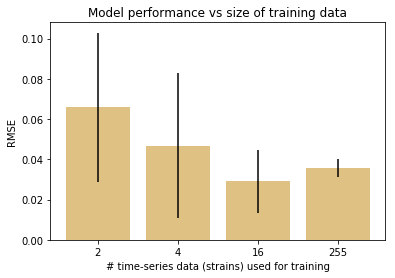

In [17]:
# barplot the RMSE

sizes = list(size_dict.keys())
means = [np.mean(size_dict[size]) for size in sizes]
stdevs = [np.std(size_dict[size]) for size in sizes]
y_pos = np.arange(len(sizes))
        
plt.bar(y_pos, means, align='center', yerr = stdevs, color=(0.8, 0.6, 0.2, 0.6))
plt.xticks(y_pos, sizes)
plt.ylabel('RMSE')
plt.xlabel('# time-series data (strains) used for training')
plt.title('Model performance vs size of training data')
plt.savefig('figures/RMSEvsSize_Gold.pdf')

plt.show()

Note that the standard deviation decreases. This std represents the stochastic effects in prediction of the dynamics (e.g. random nature of the ML algo, optimization algo, etc)